<b>Note: This file doesn't contain argument parsers, argument parsers are availabe in the .py files</b>

# Exercise 1

The Raw data has been collected using the sensor and Raspberry pi <br>
After that we have to follow two Steps. <br>
First we have to turn our raw data into a .csv file. <br>
And after that in the second part we have use that .csv file in order to create the dataset using TFRecord.

In [9]:
#code to convert the txt file containing the raw file into a csv file
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import datetime
import time
file=pd.read_csv(r'rt.txt', header=None)
file.columns = ['date', 'time', 'temperature','humidity']
file.to_csv(r'rt.csv',index=None)

The First Step in done!<br>
Now we have to use the .csv file to creat the dataset<br>
but before that, we need to change the date and time column into a POSIX timestamp

In [10]:
cols=['date','time']
conv = pd.read_csv("rt.csv",usecols=cols).values#reading the csv file
#code to convert the date and time to POSIX fornmat
timestamp=[]
for i in conv:
    temp=i[0]+' '+i[1]
    element = datetime.datetime.strptime(temp,"%d/%m/%Y %H:%M:%S")
    tuple = element.timetuple()
    timestamp.append(time.mktime(tuple))
print(timestamp)
    

[1637176627.0, 1637176632.0, 1637176637.0, 1637176643.0]


Now we have to make a new CSV file in order to use as an input to our script<br>
The new CSV file will have 3 columns

In [11]:
new_csv= pd.read_csv("rt.csv")
new_csv=new_csv.drop(['date','time'],axis=1)
new_csv.insert(0,"datetime",timestamp)


In [12]:
type(new_csv)

pandas.core.frame.DataFrame

In [13]:
new_csv

,datetime,temperature,humidity
0,1.637177e+09,22,52
1,1.637177e+09,22,52
2,1.637177e+09,22,52
3,1.637177e+09,22,52


In [15]:
# # #we delete the name of the columns

# with tf.io.TFRecordWriter(args.output) as writer:
#     for row in new_csv:
#         features, label = row[:-1], row[-1]
#         example = tf.train.Example()
#         example.features.feature["features"].float_list.value.extend(features)
#         example.features.feature["label"].float_list.value.append(label)
#         writer.write(example.SerializeToString())

TypeError: 'd' has type <class 'str'>, but expected one of: numbers.Real

We can use the code below to show the size of the output

In [7]:
#code to see the size of created TFRecord
# import os
# print(os.path.getsize(args.output))

Now we have to create the normalization function and then after that apply it to our input data<br>
and the run the code again

In [16]:
#the normalization function
def norm(t,t_min,t_max):
    return (t-t_min)/(t_max-t_min)

The <b>minimum</b> and <b>maximum</b> values for <b>temperature</b> is equal to 0 and 50 (according to the technical data sheet) <br>
The values for <b>humidity vary based on the temperature</b>:

temperature = 0  ==> humidity =  30% - 90% <br>
temperature = 25 ==> humidity =  20% - 90% <br>
temperature = 50 ==> humidity =  30% - 80% <br>
</b>
</b>
Now we have to apply the function to our data


We want to see the data we are working with, so we plot the data

<AxesSubplot:>

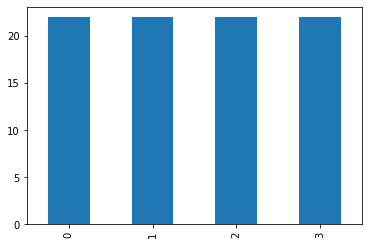

In [17]:
new_csv['temperature'].plot(kind = 'bar')


<AxesSubplot:>

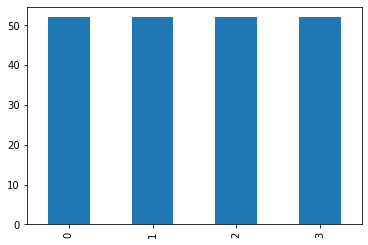

In [18]:
new_csv['humidity'].plot(kind = 'bar')


The data gathered is exactly the same during different periods of time <br>
Technically there is no need to normalize the data but since it is needed for the exercise, it'll be performed anyway

In [19]:
temperature = new_csv.loc[:,'temperature']
humidity = new_csv.loc[:,'humidity'] 

In [20]:
temperature

0    22
1    22
2    22
3    22
Name: temperature, dtype: int64

In [21]:
humidity

0    52
1    52
2    52
3    52
Name: humidity, dtype: int64

In [22]:
norm_temperature=[]
for i in temperature:
    norm_temperature.append(norm(i,0,50))    

In [23]:
norm_humidity=[]
for i in humidity:
    norm_humidity.append(norm(i,20,90))

In [24]:
print(norm_temperature)

[0.44, 0.44, 0.44, 0.44]


In [25]:
print(norm_humidity)

[0.45714285714285713, 0.45714285714285713, 0.45714285714285713, 0.45714285714285713]


Now the data is normalized and we have to create a dataframe again

In [26]:
Data={'datetime':new_csv.loc[:,'datetime'],'temperature':norm_temperature,'humidity':norm_humidity}
norm_csv=pd.DataFrame(data=Data)

In [27]:
norm_csv #normalized one 

,datetime,temperature,humidity
0,1.637177e+09,0.44,0.457143
1,1.637177e+09,0.44,0.457143
2,1.637177e+09,0.44,0.457143
3,1.637177e+09,0.44,0.457143


Data is ready to be given to our script again

In [28]:
new_csv #without normalization

,datetime,temperature,humidity
0,1.637177e+09,22,52
1,1.637177e+09,22,52
2,1.637177e+09,22,52
3,1.637177e+09,22,52


Now we have to create the new TFRecord dataset

In [22]:
with tf.io.TFRecordWriter(args.output) as writer:
    for row in new_csv:
        features, label = row[:-1], row[-1]
        example = tf.train.Example()
        example.features.feature["features"].float_list.value.extend(features)
        example.features.feature["label"].float_list.value.append(label)
        writer.write(example.SerializeToString())

In [ ]:
# code to see the size of created TFRecord
print(os.path.getsize(args.output))

At the end, We can easily compare the size of the created TFRecord datasets. 

# Exercise 2

In this exercise, we have to first import the audio file we want to use for our script

In [47]:
from subprocess import Popen
Popen('sudo sh -c "echo performance >'
 '/sys/devices/system/cpu/cpufreq/policy0/scaling_governor"', 
 shell=True).wait()

import tensorflow as tf
import os
import time
import pandas as pd 
import numpy as np
from numpy import linalg as LNG

dir_list=os.listdir('./yes_no')

In [48]:
#we have to read all the audio files and add them to a list
audio=[]
for i in dir_list:
    audio.append(tf.io.read_file('./yes_no/'+i))

In [49]:
len(audio)

2000

In [50]:
type(audio[0])

tensorflow.python.framework.ops.EagerTensor

First, we only work with one audio file to <b>test the procedure</b>

In [51]:
test_audio=tf.io.read_file('./yes_no/no_0ab3b47d_nohash_0.wav')
tf_audio, rate=tf.audio.decode_wav(test_audio)
tf_audio = tf.squeeze(tf_audio, 1)

In [52]:
import time
frame_length=16
frame_step=8
start = time.time()
stft = tf.signal.stft(tf_audio, frame_length, frame_step,
        fft_length=frame_length)
end = time.time()
print('Execution Time: {:.4f}s'.format(end-start))
spectrogram = tf.abs(stft)
print('Spectrogram shape:', spectrogram.shape)

Execution Time: 0.0270s
Spectrogram shape: (1999, 9)


Now we have the spectogram of the audio file using STFT

In [53]:
num_spectrogram_bins = spectrogram.shape[-1]
num_mel_bins = 40
sampling_rate = 16000
lower_freq=20
upper_freq=4000
coefficients=10
start = time.time()
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sampling_rate, lower_freq, upper_freq)
mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
mfccs = mfccs[..., :coefficients]
end = time.time()
print('Execution Time: {:.3f}s'.format(end-start))
print('MFCCs shape:', mfccs.shape)

Execution Time: 0.072s
MFCCs shape: (1999, 10)


Now, the testing is done and we can work on the whole dataset in order to compute MFCC<sub>slow</sub> <br>
We use a for loop for that


In [54]:
# now we get the rate of our audio
#these info are extracted from the homework pdf file
total_time=0 #to sum up the time of execution in each iteration
frame_length=16
frame_step=8
num_mel_bins = 40
sampling_rate = 16000
lower_freq=20
upper_freq=4000
coefficients=10
total_mfcc=0
for i in audio:
    tf_audio, rate = tf.audio.decode_wav(i)
    tf_audio = tf.squeeze(tf_audio, 1)
    start = time.time()
    stft = tf.signal.stft(tf_audio, frame_length, frame_step,
    fft_length=frame_length)
    spectrogram = tf.abs(stft)
    num_spectrogram_bins = spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sampling_rate, lower_freq, upper_freq)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    mfccs = mfccs[..., :coefficients]
    end = time.time()
    total_mfcc=total_mfcc+mfccs
    total_time=total_time+end-start
    
avg_time=total_time/len(audio)
avg_mfcc_slow=total_mfcc/len(audio)
print('average execution time of each iteration: ',avg_time)    

average execution time of each iteration:  0.025940912127494813


average execution time of each iteration on Raspberry pi was equal to 0.1743576855659485

Now we have to computer MFCC<sub>Fast</sub> <br>
The shape of it must be similiar to the slow one so the inputs are the same.<br>
Now we have to work with different variables and other elements in our code in order to make it more efficient

MFCC<sub>Fast</sub> is as below

We can run the script below in order to test different possible values for number of bins and fine the best one

In [55]:
# from subprocess import Popen
# import tensorflow as tf
# import os
# import time
# import pandas as pd
# import numpy as np

# Popen('sudo sh -c "echo performance >'
#       '/sys/devices/system/cpu/cpufreq/policy0/scaling_governor"',
#       shell=True).wait()

# dir_list = os.listdir('./yes_no')

# audio = []
# for i in dir_list:
#     audio.append(tf.io.read_file('./yes_no/' + i))
# frame_length = 16
# frame_step = 8
# num_mel_bins = 5
# sampling_rate = 16000
# lower_freq = 20
# upper_freq = 4000
# coefficients = 10
# tstFile = open('Detailes.txt', 'w')
# print('Starting iteration...')
# while num_mel_bins <= 80:
#     #print(num_mel_bins)
#     total_time = 0
#     for i in audio:
#         tf_audio, rate = tf.audio.decode_wav(i)
#         tf_audio = tf.squeeze(tf_audio, 1)
#         start = time.time()
#         STFT = tf.signal.stft(tf_audio, frame_length, frame_step,
#                               fft_length=frame_length)
#         spectrogram = tf.abs(STFT)
#         num_spectrogram_bins = spectrogram.shape[-1]
#         linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
#             num_mel_bins, num_spectrogram_bins, sampling_rate, lower_freq, upper_freq)
#         mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
#         log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
#         mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
#         mfccs = mfccs[..., :coefficients]
#         end = time.time()
#         temp_time = end - start
#         total_time = total_time + temp_time


#     avg_time = total_time / len(audio)
#     txt = 'Bin: ' + str(num_mel_bins) + '\tavg time: ' + str(avg_time) + '\n'
#     tstFile.write(txt)
#     num_mel_bins = num_mel_bins + 10
#     print(txt)
#     # print('Bin: ', num_mel_bins, '\tavg time: ', avg_time)
# tstFile.close()
# print('Done Sire')

The output of the above cell is available in the test_result.txt file
<br>You can completely <b>ignore</b> the above cell

In [77]:
# now we get the rate of our audio
#these info are extracted from the homework pdf file
total_time=0#to sum up the time of execution in each iteration
frame_length=16
frame_step=8
num_mel_bins = 12
sampling_rate = 16000
lower_freq=20
upper_freq=4000
coefficients=10
total_mfcc=0
for i in audio:
    tf_audio, rate = tf.audio.decode_wav(i)
    tf_audio = tf.squeeze(tf_audio, 1)
    start = time.time()
    stft = tf.signal.stft(tf_audio, frame_length, frame_step,
    fft_length=frame_length)
    spectrogram = tf.abs(stft)
    num_spectrogram_bins = spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sampling_rate, lower_freq, upper_freq)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    mfccs = mfccs[..., :coefficients]
    end = time.time()
    total_mfcc=total_mfcc+mfccs
    total_time=total_time+end-start
    total_time=total_time+end-start
    
avg_time=total_time/len(audio)
avg_mfcc_fast=total_mfcc/len(audio)

print('average execution time of each iteration: ',avg_time)    

average execution time of each iteration:  0.023845387935638427


The SNR code is as below

In [78]:
def SNR(MFCC_slow, MFCC_fast):
    Numerator = LNG.norm(MFCC_slow)
    Denominator = LNG.norm(MFCC_slow - MFCC_fast + 10 ** -6)
    SNR_result = 20 * np.log(Numerator / Denominator)
    return SNR_result

In [79]:
#now we run the SNR function
SNR(avg_mfcc_slow,avg_mfcc_fast)

11.479350328445435

We had to make a trade off between the execution time and SNR</br>
in order to get the min exection time we had to set the number of bin equal to 1 </br>
but that doesn't give us a good SNR so we had to change it and set it equla to 12 (after testing different values for the number of bins)</br>

# Final note
<b>The code has been tested on Raspberry pi 4 and the .py files are uploaded. This file is for the sole purpose of having a btter understanding of the whole procedure. </b>
 

In [1]:
from subprocess import Popen
import tensorflow as tf
import os
import time
import numpy as np
import pandas as pd
from numpy import linalg as LNG

Popen('sudo sh -c "echo performance >'
      '/sys/devices/system/cpu/cpufreq/policy0/scaling_governor"',
      shell=True).wait()


def SNR(mfcc_slow, mfcc_fast):
    numerator = LNG.norm(mfcc_slow)
    denominator = LNG.norm(mfcc_slow - mfcc_fast + 10 ** -6)
    snr_result = 20 * np.log(numerator / denominator)
    print('SNR = ' + str(snr_result) + ' dB')


def mfcc(bins, Audio, types):
    tot_mfcc = 0
    total_time = 0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        bins, 129 , sampling_rate, lower_freq, upper_freq)
    for i in Audio:
        tf_audio, rate = tf.audio.decode_wav(i)
        tf_audio = tf.squeeze(tf_audio, 1)
        start = time.time()
        stft = tf.signal.stft(tf_audio, frame_length, frame_step,
                              fft_length=frame_length)
        spectrogram = tf.abs(stft)
        num_spectrogram_bins = spectrogram.shape[-1]
        #linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      # bin, num_spectrogram_bins, sampling_rate, lower_freq, upper_freq)
        mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        log_mel_spectrogram = tf.math.log(mel_spectrogram + 1.e-6)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
        mfccs = mfccs[..., :coefficients]
        end = time.time()
        tot_mfcc = tot_mfcc + mfccs
        temp_time = end - start
        total_time = total_time + temp_time
    avg_time = total_time / len(audio)
    avg_mfcc = tot_mfcc / len(audio)
    print('MFCC ' + types + ' = ', int(avg_time*1000), ' ms')
    print(tf.shape(avg_mfcc))
    return avg_mfcc


frame_length = 256
frame_step = 128

sampling_rate = 16000
lower_freq = 20
upper_freq = 4000
coefficients = 10

DATASET_PATH = './yes_no'
dir_list = os.listdir(DATASET_PATH)
audio = []
for i in dir_list:
    audio.append(tf.io.read_file(DATASET_PATH+'/'+i))

mfcc_slow = mfcc(bins=40, Audio=audio, types='slow')
mfcc_fast = mfcc(bins=5, Audio=audio, types='fast')
SNR(mfcc_slow=mfcc_slow, mfcc_fast=mfcc_fast)

MFCC slow =  5  ms
tf.Tensor([124  10], shape=(2,), dtype=int32)
MFCC fast =  3  ms
tf.Tensor([124   5], shape=(2,), dtype=int32)


InvalidArgumentError: Incompatible shapes: [124,10] vs. [124,5] [Op:Sub]

In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import argparse
import datetime
import time
# import adafruit_dht
import os


def norm(t, t_min, t_max):
    return (t - t_min) / (t_max - t_min)


parser = argparse.ArgumentParser()
parser.add_argument('--input', type=str, help='specify the csv input file')
parser.add_argument('--output', type=str, help='specify output file name with tfrecord extension')
parser.add_argument('--normalize', action="store_true", help='for normalizing the humidity and temperature')
args = parser.parse_args()

# Code to get humidity & Tempreture from sendor and save in a CSV file
# period = 60
# freq = 5
# num_samples = int(period // freq)
# dht_device = adafruit_dht.DHT11(D4)
# for i in range(num_samples):
#     now = datetime.datetime.now()
#     temperature = dht_device.temperature
#     humidity = dht_device.humidity
#     print('{:02}/{:02}/{:04},{:02}:{:02}:{:02},{:},{:}'.format(now.day, now.month, now.year, now.hour, now.minute,
#                                                                now.second, temperature, humidity), file=fp)
#     time.sleep(args.f)
# file = pd.read_csv('rt.txt', header=None)
# file.columns = ['date', 'time', 'temperature', 'humidity']
# file.to_csv('rt.csv', index=None)

cols = ['date', 'time']
conv = pd.read_csv(args.input, usecols=cols).values  # reading the csv file

# code to convert the date and time to POSIX fornmat
timestamp = []
for i in conv:
    temp = i[0] + ' ' + i[1]
    element = datetime.datetime.strptime(temp, "%d/%m/%Y %H:%M:%S")
    tmp_tuple = element.timetuple()
    timestamp.append(time.mktime(tmp_tuple))
new_csv = pd.read_csv("rt.csv")
new_csv = new_csv.drop(['date', 'time'], axis=1)
new_csv.insert(0, "datetime", timestamp)
new_csv = new_csv.astype({'temperature': int})
new_csv = new_csv.values

if args.normalize:
    temperature = new_csv.loc[:, 'temperature']
    humidity = new_csv.loc[:, 'humidity']
    norm_temperature = []
    norm_humidity = []
    for i in temperature:
        norm_temperature.append(norm(i, 0, 50))
    for i in humidity:
        norm_humidity.append(norm(i, 20, 90))
    Data = {'datetime': new_csv.loc[:, 'datetime'], 'temperature': norm_temperature, 'humidity': norm_humidity}
    norm_csv = pd.DataFrame(data=Data)

with tf.io.TFRecordWriter(args.output) as writer:
    for row in new_csv:
        # features, label = row[:-1], row[-1]
        features = row
        example = tf.train.Example()
        example.features.feature["features"].float_list.value.extend(features)
        # example.features.feature["label"].float_list.value.append(label)
        writer.write(example.SerializeToString())

print(os.path.getsize(args.output))


usage: ipykernel_launcher.py [-h] [--input INPUT] [--output OUTPUT] [--normalize]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\aligh\AppData\Roaming\jupyter\runtime\kernel-09e27e38-f7e6-4b2b-baa0-64c25960fa35.json


SystemExit: 2

C:\Users\aligh\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
